In [42]:
import sys
sys.path.append('../')
import pandas as pd
import backtrader as bt
from datetime import datetime
import matplotlib.pyplot as plt
from Tools.backtest_tools import *
from Tools.plotting import CandlePlot
import pandas_ta as ta

In [43]:
# Load the data and convert the timestamp to datetime
df = pd.read_csv('../DB/5m/INJUSDT_5m.csv', parse_dates=True) 

# df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
# # # Convert 'date' to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])  # Assuming the 'date' is in milliseconds

# # # Set 'date' as index
df.set_index('datetime', inplace=True)

# df.iloc[0]
# df.dtypes
# df.head()
df_t = df[:].copy()

In [44]:
params = {
    "trix_length": 35,
    "trix_signal_length": 7,
    "trix_signal_type": "sma",
    "long_ma_length": 50,
    "long_ma_type": "sma",
}

In [45]:
class Strategy():
    def __init__(
        self,
        df,
        type=['long', 'short'],
        params=params,
    ):
        self.df = df.copy()
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.params = params

    def populate_indicators(self):
        df = self.df
        params = self.params
        df.drop(
            columns=df.columns.difference(['open','high','low','close','volume']), 
            inplace=True
        )

        trix_obj = Trix(close=df["close"], trix_length=params['trix_length'], trix_signal_length=params['trix_signal_length'], trix_signal_type=params['trix_signal_type'])

        df['trix'] = trix_obj.get_trix_pct_line()
        df['trix_signal'] = trix_obj.get_trix_signal_line()
        df['trix_hist'] = df['trix'] - df['trix_signal']

        if params['long_ma_type'] == "ema":
            df["long_ma"] = ta.ema(df["close"], length=params['long_ma_length'])
        else:
            df["long_ma"] = ta.sma(df["close"], length=params['long_ma_length'])
        
        self.df = df
        return self.df
    
    def populate_buy_sell(self): 
        df = self.df
        params = self.params
        # -- Initiate populate --
        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False

        if self.use_long:
            df.loc[
                (df["trix_hist"] > 0) &
                (df['close'] > df["long_ma"])
                , "open_long_market"
            ] = True

            df.loc[
                (df["trix_hist"] < 0)
                , "close_long_market",
            ] = True

        if self.use_short:
            df.loc[
                (df["trix_hist"] < 0) &
                (df['close'] < df["long_ma"])
                , "open_short_market"
            ] = True

            df.loc[
                (df["trix_hist"] > 0)
                , "close_short_market",
            ] = True

        self.df = df   
        return self.df
    
    def run_backtest(self, initial_wallet=1000, start_date=None, end_date=None):
        if start_date:
            self.df = self.df.loc[start_date:]
        if end_date:
            self.df = self.df.loc[:end_date]

        df = self.df
        params = self.params
        wallet = initial_wallet
        maker_fee = 0.0002
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        for index, row in df.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":                     
                    # -- Close LONG --
                    if row["close_long_market"]:
                        if row["close_long_market"]:
                            close_price = row["close"]
                            close_reason = "Market"
                            fee_apply = taker_fee
                        trade_result = (
                            close_price - current_position["price"]
                        ) / current_position["price"]
                        wallet += wallet * trade_result
                        fee = wallet * fee_apply
                        wallet -= fee
                        trades.append(
                            {
                                "open_date": current_position["date"],
                                "close_date": index,
                                "position": "LONG",
                                "open_reason": current_position["reason"],
                                "close_reason": close_reason,
                                "open_price": current_position["price"],
                                "close_price": close_price,
                                "open_fee": current_position["fee"],
                                "close_fee": fee,
                                "open_trade_size": current_position["size"],
                                "close_trade_size": wallet,
                                "wallet": wallet,
                            }
                        )
                        current_position = None

                elif current_position['side'] == "SHORT":                     
                    # -- Close SHORT --
                    if row["close_short_market"]:
                        if row["close_short_market"]:
                            close_price = row["close"]
                            close_reason = "Market"
                            fee_apply = taker_fee
                        trade_result = (
                            current_position["price"] - close_price
                        ) / current_position["price"]
                        wallet += wallet * trade_result
                        fee = wallet * fee_apply
                        wallet -= fee
                        trades.append(
                            {
                                "open_date": current_position["date"],
                                "close_date": index,
                                "position": "SHORT",
                                "open_reason": current_position["reason"],
                                "close_reason": close_reason,
                                "open_price": current_position["price"],
                                "close_price": close_price,
                                "open_fee": current_position["fee"],
                                "close_fee": fee,
                                "open_trade_size": current_position["size"],
                                "close_trade_size": wallet,
                                "wallet": wallet,
                            }
                        )
                        current_position = None

            # -- Check for opening position --
            else:
                # -- Open long market --
                if row['open_long_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                # -- Open short market --
                elif row['open_short_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT",
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! No trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])
            self.trades = df_trades
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days,
            "params": self.params
        }
    
    def plot(self, win):
        
        dfplt = self.df[win:win+1000]
        cp = CandlePlot(dfplt)
            # Find the date range in dfplt
        start_date = dfplt.index.min()  # assuming dfplt index is datetime
        end_date = dfplt.index.max()
        
        # Filter trades within the date range of dfplt
        trades_in_range = self.trades[
            ((self.trades['open_date'] >= start_date) & (self.trades['open_date'] <= end_date)) |
            ((self.trades['close_date'] >= start_date) & (self.trades['close_date'] <= end_date))
        ]
        cp.add_traces([ 'long_ma'])
        cp.add_entries(trades_in_range)
        cp.show_plot()

In [46]:
strat = Strategy(df_t, params=params)

In [47]:
strat.populate_indicators()
# strat.generate_signals()
strat.populate_buy_sell()
# strat.trades
bt_result = strat.run_backtest(initial_wallet=1000)
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])


Period: [2022-11-21 00:00:00] -> [2024-09-04 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 0.3 $
Performance vs US dollar: -99.97 %
Sharpe Ratio: -4.18
Worst Drawdown T|D: -99.98% | -99.97%
Buy and hold performance: 919.56 %
Performance vs buy and hold: -100.0 %
Total trades on the period: 4309
Global Win rate: 33.6 %
Average Profit: -0.17 %
Total fees paid 816.82$

Best trades: +22.68 % the 2023-03-12 16:35:00 -> 2023-03-13 01:40:00
Worst trades: -9.77 % the 2023-12-11 02:10:00 -> 2023-12-11 03:10:00


In [48]:
strat.plot(-2000)

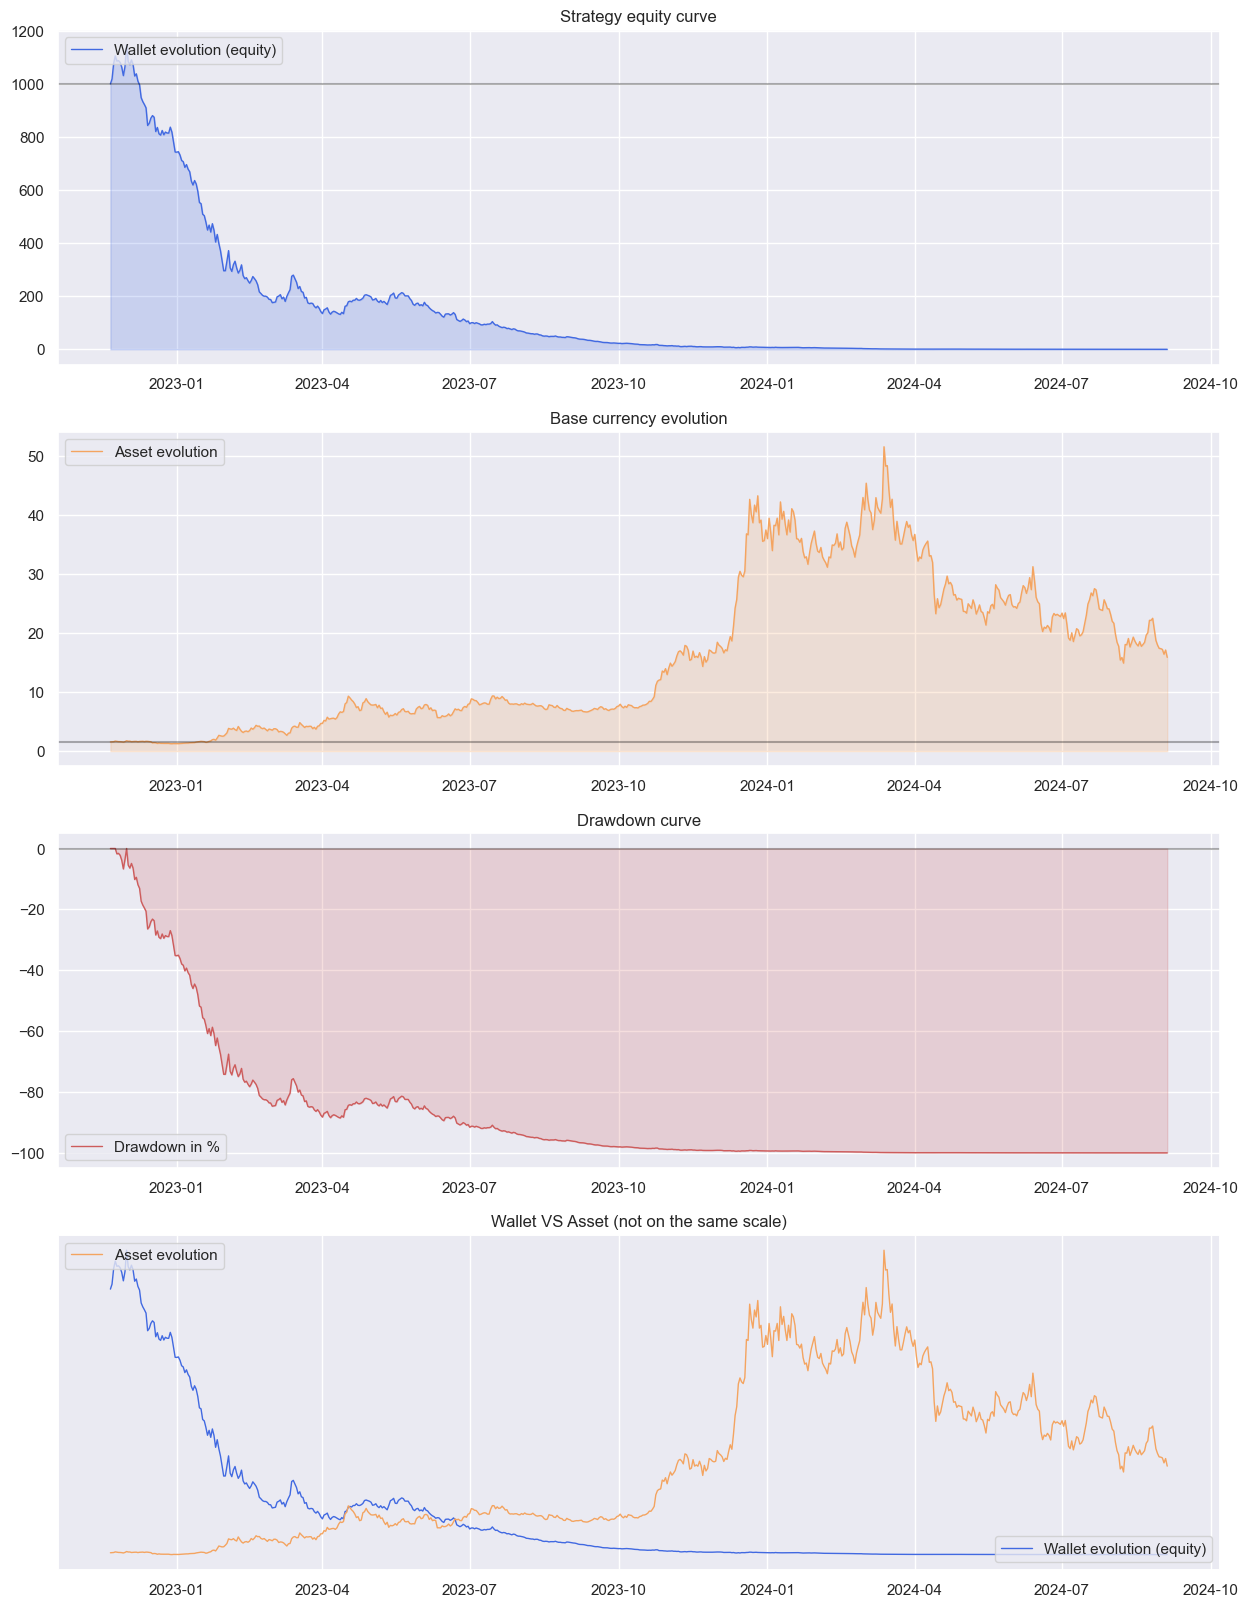

In [49]:
plot_wallet_vs_asset(df_days=df_days)

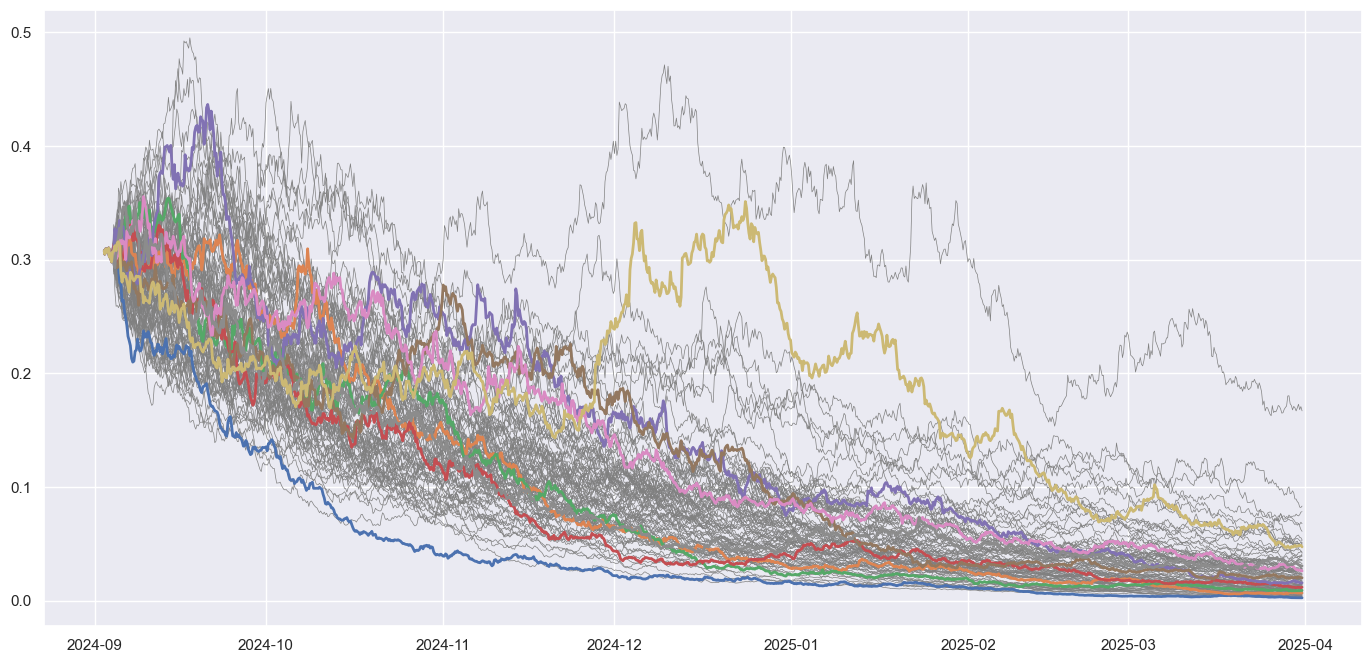

In [50]:
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=1,
    trades_to_forecast=1000,
    number_of_simulations=100,
    true_trades_to_show=10,
    show_all_simulations=True,
)

----- 2022 Cumulative Performances: -25.67% -----


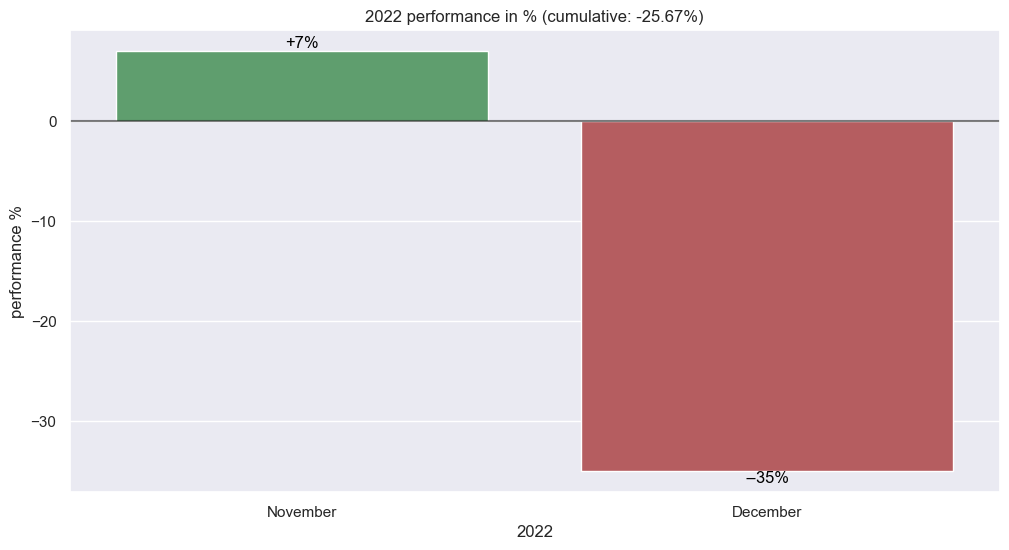

----- 2023 Cumulative Performances: -99.01% -----


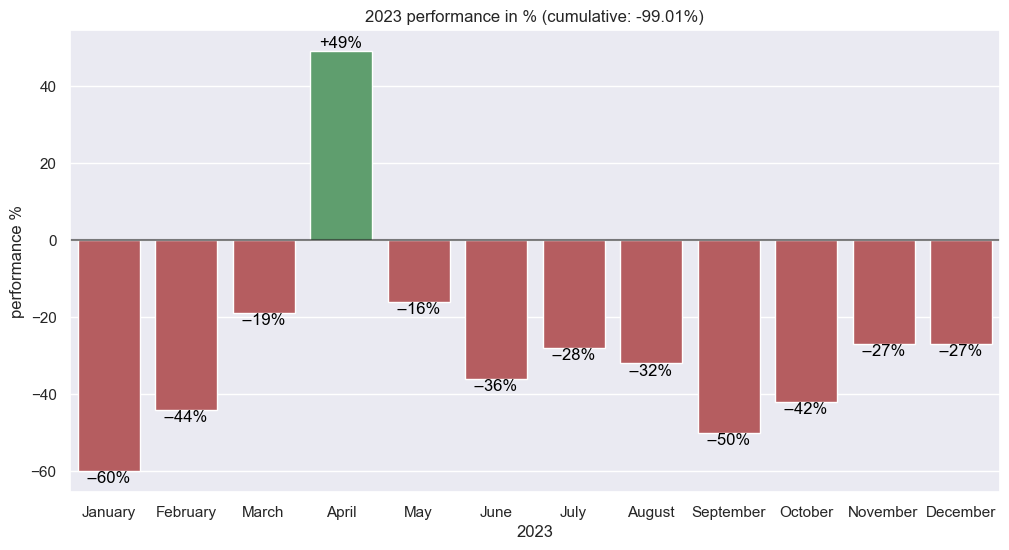

----- 2024 Cumulative Performances: -95.65% -----


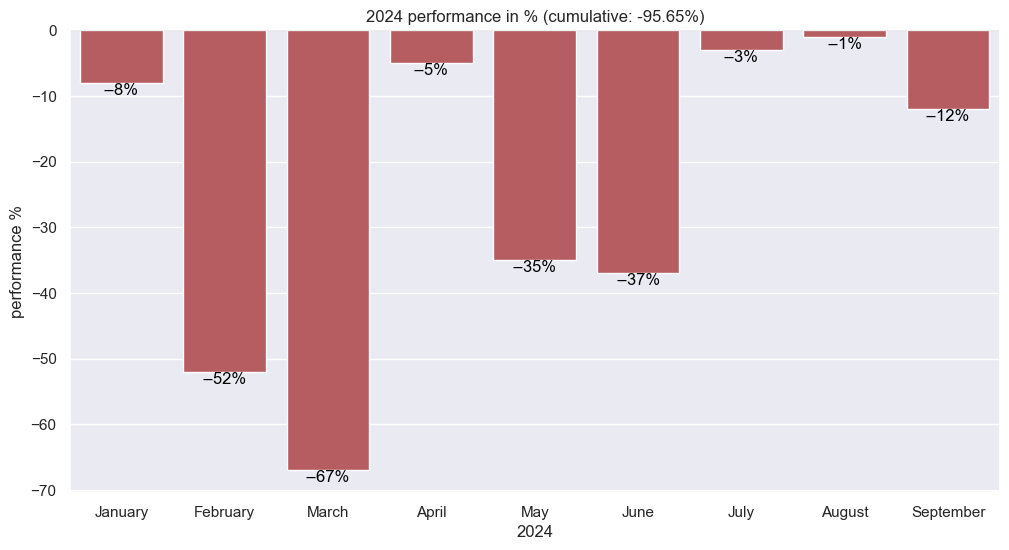

In [51]:
plot_bar_by_month(df_days=df_days)